In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from collections import OrderedDict
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
class MNISTmodel(nn.Module):
    """
    paper implementation 'https://arxiv.org/abs/1711.06104'
    
    model_type: 
        - DNN: 
            Linear: 28*28, 512 
            Linear: 512, 512
            Linear: 512, 10
        - CNN: 
            Conv2d: (1, 32, 3)
            Conv2d: (32, 64, 3)
            MaxPool2d: (2)
            Linear: (64*12*12, 128)
            Linear: (128, 10)

            ** Conv2d = (in_kernels, out_kernels, kernel_size)
            ** MAxPool2d = (kernel_size)

    activation_type:
        - ReLU, Tanh, Sigmoid, Softplus
    """
    def __init__(self, model_type, activation_type):
        """
        model_type: "dnn", "cnn"
        activation_type: "relu", "tanh", "sigmoid", "softplus"
        """
        super(MNISTmodel, self).__init__()
        self.act = {"relu": nn.ReLU, 
                    "tanh": nn.Tanh, 
                    "sigmoid": nn.Sigmoid, 
                    "softplus": nn.Softplus}
        
        self.convs, self.fc = self.make_layers(model_type, activation_type)
        
        if model_type == "cnn":
            self.switches = OrderedDict()
            self.maxpool2d_locs = []
            self.convs_len = len(self.convs)
            
        self.activation_maps = OrderedDict()
        self.activation_locs = []
        self.fc_len = len(self.fc)
        
    def make_layers(self, model_type, activation_type):
        self.activation_func = self.act[activation_type.lower()]
        if model_type.lower() == "dnn":
            convs = None
            fc = nn.Sequential(
                nn.Linear(28*28, 512),
                self.activation_func(), 
                nn.Linear(512, 512),
                self.activation_func(), 
                nn.Linear(512, 10),
            )
        elif model_type.lower() == "cnn":
            convs = nn.Sequential(
                nn.Conv2d(1, 32, 3),
                self.activation_func(),
                nn.Conv2d(32, 64, 3),
                self.activation_func(), 
                nn.MaxPool2d(2, return_indices=True),
            )
            fc = nn.Sequential(
                nn.Linear(64*12*12, 128),
                self.activation_func(),
                nn.Linear(128, 10)
            )
        else:
            assert False, "please insert `model_type` = `dnn` or `cnn`"
        return convs, fc    
    
    def save_activation_maps(self, layer, idx, x, typ, indices=None):
        if isinstance(layer, self.activation_func):
            layer_name = f"{typ}{idx}"
            self.activation_locs.append(layer_name)
            self.activation_maps[layer_name] = x
    
    def forward(self, x, store=False):
        # conv layers
        if self.convs is not None:
            for idx, layer in enumerate(self.convs):
                if isinstance(layer, nn.MaxPool2d):
                    x, indices = layer(x)
                    self.switches[idx] = indices
                    self.maxpool2d_locs.append(idx)
                else:
                    x = layer(x)
                    if store:
                        self.save_activation_maps(layer, idx, x, typ="convs")
        # resize
        x = x.view(x.size(0), -1)
        # fc layers
        for idx, layer in enumerate(self.fc, (self.convs_len+self.fc_len-2)*int(bool(self.convs))):
            x = layer(x)
            if store:
                self.save_activation_maps(layer, idx, x, typ="fc")
        return x

In [3]:
class explainMNISTmodel(nn.Module):
    def __init__(self, model_type, activation_type):
        """
        model_type: "dnn", "cnn"
        activation_type: "relu", "tanh", "sigmoid", "softplus"
        """
        super(explainMNISTmodel, self).__init__()
        self.act = {"relu": nn.ReLU, 
                    "tanh": nn.Tanh, 
                    "sigmoid": nn.Sigmoid, 
                    "softplus": nn.Softplus}
        
        self.convs, self.fc = self.make_layers(model_type, activation_type)
        
        if model_type == "cnn":
            self.switches = OrderedDict()
            self.maxpool2d_locs = []
            self.convs_len = len(self.convs)
            
        self.activation_maps = OrderedDict()
        self.activation_locs = []
        self.fc_len = len(self.fc)
        
    def make_layers(self, model_type, activation_type):
        self.activation_func = self.act[activation_type.lower()]
        if model_type.lower() == "dnn":
            convs = None
            fc = nn.Sequential(
                nn.Linear(10, 512),
                self.activation_func(), 
                nn.Linear(512, 512),
                self.activation_func(), 
                nn.Linear(512, 28*28),
            )
        elif model_type.lower() == "cnn":
            fc = nn.Sequential(
                nn.Linear(10, 128),
                self.activation_func(),
                nn.Linear(128, 64*12*12)    
            )
            convs = nn.Sequential(
                nn.MaxUnpool2d(2),
                self.activation_func(), 
                nn.ConvTranspose2d(64, 32, 3),
                self.activation_func(),
                nn.ConvTranspose2d(32, 1, 3),
            )
        else:
            assert False, "please insert `model_type` = `dnn` or `cnn`"
        return convs, fc    

    def forward(self, x, switches):  
        x = self.fc(x)
        x = x.view(x.size(0), 28, 28)
        if self.convs is not None:
            for idx, layer in enumerate(self.convs):
                if isinstance(layer, nn.MaxUnpool2d):
                    x = layer(x, switches[self.convs_len - 1 - idx])
                    self.switches = indices
                else:
                    x = layer(x)
        return x

In [4]:
def build_dataset(root, batch_size, download=False):
    train_dataset = datasets.MNIST(
        root=root,                                
        train=True,
        transform=transforms.Compose([
           transforms.ToTensor(),
           transforms.Normalize((0.5,), (0.5,))  # normalize to (-1, 1)
        ]),
        download=download)
    test_dataset = datasets.MNIST(
        root=root, 
        train=False,
        transform=transforms.Compose([
           transforms.ToTensor(),
           transforms.Normalize((0.5,), (0.5,))
        ]),
        download=download)
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size, 
        shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size, 
        shuffle=True)
    return train_dataset, test_dataset, train_loader, test_loader

In [5]:
activation_types = ["relu", "tanh", "sigmoid", "softplus"]
model_types = ["dnn", "cnn"]
args = dict(
    root = Path().home()/"code"/"data",
    project_path = Path().home()/"code"/"XAI",
    logterm = False, 
    sv_folder = "mnist", 
    n_step = 20,
    batch_size = 128,
    download = False,
    device = "cuda" if torch.cuda.is_available() else "cpu",
    seed = 73
)
train_dataset, test_dataset, train_loader, test_loader = build_dataset(str(args["root"]), 1)

In [47]:
def create_model(model_type, activation_type, load=True):
    model = MNISTmodel(model_type, activation_type)
    ex_model = explainMNISTmodel(model_type, activation_type)
    if load:
        model.load_state_dict(torch.load(f"./trained/mnist/{model_type}-{activation_type}.pt", map_location="cpu"))
    return model, ex_model

def run_backward(x, oc_x, target, model):
    loss_function = nn.CrossEntropyLoss()
    ret = []
    for img in [x, oc_x]:
        img = img.requires_grad_()
        model.zero_grad()
        output = model(img, store=True)
        pred = output.argmax(1) 
        loss = loss_function(output, target)
        loss.backward()
        ret.append((img.grad, pred))
    return ret

def unnormalize(x, mean=0.5, std=0.5):
    return (x*0.5) + 0.5

def draw_activaion_map(model):
    fig, axes = plt.subplots(1, 2, figsize=(6, 24))

    for ax, layer_name in zip(axes, model.activation_locs):
        if "conv" in layer_name:
            act_map = model.activation_maps[layer_name].max(1)[0].detach().squeeze()
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            im = ax.imshow(act_map, cmap="gray")
            fig.colorbar(im, cax=cax, orientation='vertical')
            ax.set_title(f"{layer_name} \n{list(act_map.size())}")
    
    plt.tight_layout()
    plt.show()
    
def draw_gradient_map(grad, oc_grad, inp, oc_inp):
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))
    titles = ["original\ngradient", "occluded\ngradient", "gradient*input", "occluded\ngradient*input"]
    gradients = [grad, oc_grad, unnormalize(inp.detach())*grad, unnormalize(oc_inp.detach())*grad]
    
    for ax, g, t in zip(axes.flatten(), gradients, titles):
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        im = ax.matshow(g.squeeze(), cmap="coolwarm")
        ax.xaxis.tick_bottom()
        fig.colorbar(im, cax=cax, orientation='vertical')
        ax.set_title(f"{t}")
        
    plt.tight_layout()
    plt.show()

In [44]:
torch.manual_seed(74)
for imgs, labels in test_loader:
    break
    
num = 1
sample = imgs[:num]
sample_label = labels[:num]

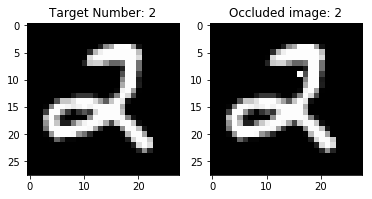

In [45]:
mask = torch.ones(1, 1, 28, 28)
mask[0, 0, 9, 16] = -1
oc_sample = sample * mask

fig, axes = plt.subplots(1, 2)
axes[0].imshow(unnormalize(sample.squeeze()), cmap="gray")
axes[0].set_title(f"Target Number: {sample_label.item()}")

axes[1].imshow(unnormalize(oc_sample.squeeze()), cmap="gray")
axes[1].set_title(f"Occluded image: {sample_label.item()}")

plt.show()

In [46]:
model_type = "cnn"
activation_type = "relu"

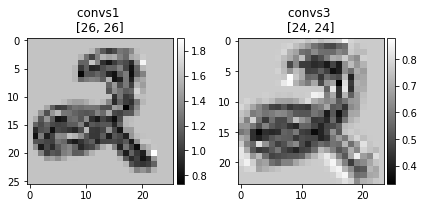

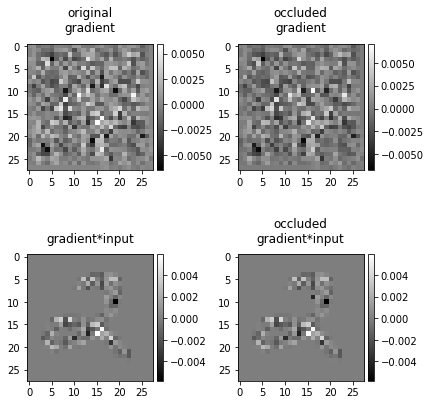

In [48]:
# Before load trained: check how activation map
torch.manual_seed(73)

model, ex_model = create_model(model_type, activation_type, load=False)
# Occlusion
(sample_grad, pred), (oc_sample_grad, oc_pred) = run_backward(sample, oc_sample, sample_label, model)
draw_activaion_map(model)
draw_gradient_map(sample_grad, oc_sample_grad, sample, occluded_sample)

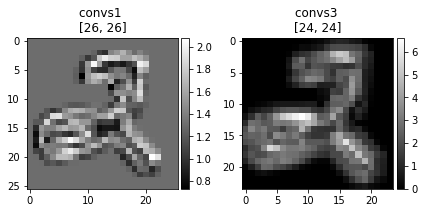

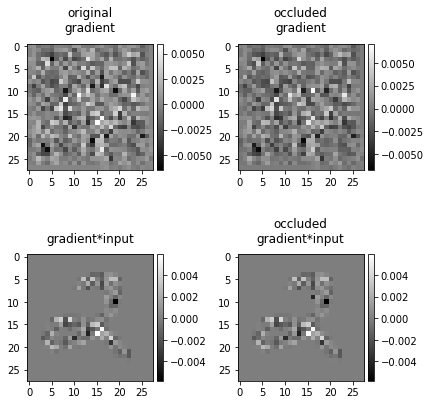

In [49]:
torch.manual_seed(73)

model, ex_model = create_model(model_type, activation_type, load=True)
# Occlusion
(sample_grad, pred), (oc_sample_grad, oc_pred) = run_backward(sample, oc_sample, sample_label, model)
draw_activaion_map(model)
draw_gradient_map(sample_grad, oc_sample_grad, sample, occluded_sample)